In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input,ReLU
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import random

tf.config.list_physical_devices(), tf.__version__

2024-10-17 09:53:54.058724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-17 09:53:54.192600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-17 09:53:54.193565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 09:53:54.327307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-17 09:53:56.421286: W tensorflow/compiler/tf

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.16.2')

In [2]:
rescale = lambda x,y: ((x/255.0) ,y) # rescale image from 0...255 to 0...1
preprocess = lambda x,y: ((x-0.5)/0.5 ,y) # normalize images from 0...1 to -1...1
rotate = RandomRotation(factor=0.4,name="rotate") # rotates image
flip = RandomFlip(mode="horizontal_and_vertical",name="flip") # flips images
zoom = RandomZoom(height_factor=(-0.2, -0.2), name="zoom") # zooms into image
display_model = lambda x,y: plot_model(x,show_shapes=True,show_layer_names=True,to_file=f'{y}.png',show_layer_activations=True) # helper function to plot model

2024-10-17 09:54:00.358849: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 09:54:00.359058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 09:54:00.359146: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 09:54:00.952829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 09:54:00.952952: I external/local_xla/xla/stream_executor

In [3]:
no_of_class = 102 # total class
IMG_SIZE = (64,64) # desired image size
BATCH = 24 # batch-size (use only batch_size which is multiple of 3/6/12/24)

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)

# applying preprocessing (rescale,preprocess)
train = train.map(rescale) 
train = train.map(preprocess)
#train = train.map(lambda x,y: (rotate(x),y))
#train = train.map(lambda x,y: (flip(x),y))

Found 6552 files belonging to 102 classes.


2024-10-17 09:54:03.592174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


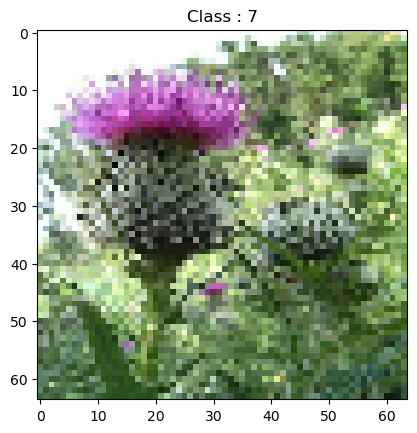

In [4]:
# sampling a image

for i,j in train.take(1):
    plt.imshow(i[0].numpy()*0.5+0.5)
    plt.title(f'Class : {j[0].numpy()}')

In [5]:
latent_dim = np.array([4,4,1024]) # the latent space we will derive images from
noise_shape = 512 # shape of noise vector/array/tensor

# base upsampling/convo Transpose layers
class upsample_class():
    def __init__(self) -> None:
        self.count = 0
    
    def __call__(self,filters:int,strides:int,kernel:int,input:keras.Layer) -> keras.Layer:
        self.count += 1
        
        x = Conv2DTranspose(filters,(kernel,kernel),strides=strides,padding='same', name=f'conv_{self.count}',use_bias=False)(input)
        x = BatchNormalization(name=f'norm_{self.count}')(x)
        x = ReLU(name=f'relu_{self.count}')(x)
        return x
    

# make generator (Input -> noise,label : Output -> img)
def make_generator_wgan(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,512,name='label_embedding')(label_input)
    l = Dense(np.prod(latent_dim)//2,name='label_dense')(l)
    l = Flatten(name='label_flatten')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim)//2,name='noise_dense')(noise_input)
    n = Flatten(name='noise_flatten')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    x = Reshape(latent_dim,name='Merged_label')(merge)
    x = BatchNormalization(name='Merged_norm')(x)
    x = ReLU(name='Merged_Relu')(x)
    
    upsample_block = upsample_class()
    
    x = upsample_block(filters=512, strides=2,kernel=4,input=x)
    x = upsample_block(filters=256,strides=2,kernel=5,input=x)
    x = upsample_block(filters=128,strides=2,kernel=5,input=x)
    x = upsample_block(filters=64,strides=2,kernel=5,input=x)  
        
    x = Conv2DTranspose(3,(3,3),strides=1,padding='same', name='final',activation='tanh')(x) # tanh to normalize values between -1 and 1
    
    generator = tf.keras.Model([noise_input,label_input],x,name='AC_Generator')
    
    return generator

make_generator_wgan(no_of_class,noise_shape,latent_dim).summary()

Model: "AC_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 512)    │     52,224 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 8192)      │  4,202,496 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 8192)   │  4,202,496 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_flatten       │ (None, 8192)      │          0 │ noise_dense[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_flatten       │ (None, 8192)      │          0 │ label_dense[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16384)     │          0 │ noise_flatten[0]… │
│ (Concatenate)       │                   │            │ label_flatten[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged_label        │ (None, 4, 4,      │          0 │ concatenate[0][0] │
│ (Reshape)           │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged_norm         │ (None, 4, 4,      │      4,096 │ Merged_label[0][… │
│ (BatchNormalizatio… │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged_Relu (ReLU)  │ (None, 4, 4,      │          0 │ Merged_norm[0][0] │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 8, 8, 512) │  8,388,608 │ Merged_Relu[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 8, 8, 512) │      2,048 │ conv_1[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1 (ReLU)       │ (None, 8, 8, 512) │          0 │ norm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 16, 16,    │  3,276,800 │ relu_1[0][0]      │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 16, 16,    │      1,024 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_2 (ReLU)       │ (None, 16, 16,    │          0 │ norm_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 32, 32,    │    819,200 │ relu_2[0][0]    

 Total params: 21,156,291 (80.70 MB)

 Trainable params: 21,152,323 (80.69 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [6]:
# base downsampling/convo layers

class discriminator_class():
    def __init__(self) -> None:
        self.count = 0
        
    def __call__(self,filters:int,strides:int,input:keras.Layer) -> keras.Layer:
        self.count += 1
        
        x = Conv2D(filters=filters, kernel_size=(4,4), strides=strides, padding='same', name=f'Convo_{self.count}')(input)
        x = LeakyReLU(name=f'Leaky_{self.count}')(x)
        x = BatchNormalization(name=f'Batch_Norm_{self.count}')(x)
        x = Dropout(0.1,name=f'Dropout_{self.count}')(x)
        return x
    
# make the discriminator(Input-> img,label : Output -> class,real/fake)
def make_discriminator_wgan(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,1024,name='label_embedding')(label_input)
    l = Dense(np.prod(img),name='label_dense')(l)
    l = Reshape((img[0],img[1],1),name='label_reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')
        
    merge = Concatenate(name='concatenate')([img_input,l])
    
    discriminator_block = discriminator_class()
    
    x = discriminator_block(64,2,merge)
    x = discriminator_block(128,2,x)
    x = discriminator_block(256,2,x)
    x = discriminator_block(512,2,x)
    x = discriminator_block(1024,2,x)
    
    
    x = Flatten(name='flatten')(x)
    
    
    label_based = Dense(no_of_class,activation='softmax',name='label_predict')(x) # softmax to condense the array into probability
    
    real_based = Dense(1,name='real_predict')(x) # implementating wgan, no need of activations
    
    discriminator = tf.keras.Model([img_input,label_input],[label_based,real_based],name='AC_Discriminator')
    
    return discriminator

make_discriminator_wgan(IMG_SIZE,no_of_class).summary()

Model: "AC_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 1024)   │    104,448 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 4096)   │  4,198,400 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_reshape       │ (None, 64, 64, 1) │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64, 4) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ label_reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_1 (Conv2D)    │ (None, 32, 32,    │      4,160 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 32, 32,    │          0 │ Convo_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch_Norm_1        │ (None, 32, 32,    │        256 │ Leaky_1[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ Batch_Norm_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_2 (Conv2D)    │ (None, 16, 16,    │    131,200 │ Dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 16, 16,    │          0 │ Convo_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch_Norm_2        │ (None, 16, 16,    │        512 │ Leaky_2[0][0]     │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ Batch_Norm_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_3 (Conv2D)    │ (None, 8, 8, 256) │    524,544 │ Dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_3 (LeakyReLU) │ (None, 8, 8, 256) │          0 │ Convo_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch_Norm_3        │ (None, 8, 8, 256) │      1,024 │ Leaky_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 8, 8, 256) │          0 │ Batch_Norm_3[0][

 Total params: 15,879,975 (60.58 MB)

 Trainable params: 15,876,007 (60.56 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [1]:
def dis_loss(real_output,generated_output):
    return tf.reduce_mean(generated_output) - tf.reduce_mean(real_output)

def gen_loss(generated_output):
    return -tf.reduce_mean(generated_output)

In [26]:
# WCGAN Class
class WCGAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int],dis_steps:int,batch:int,gp_weight:int) -> None:
        super(WCGAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.dis_steps = dis_steps
        self.img = img_shape
        self.batch = batch
        self.gp_weight = gp_weight
        self.generator = make_generator_wgan(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_wgan(self.img,no_of_class)
        self.gen_loss = tf.keras.metrics.Mean(name="generator_loss")
        self.dis_real_loss = tf.keras.metrics.Mean(name="discriminator_real_loss")
        self.dis_class_loss = tf.keras.metrics.Mean(name="discriminator_class_loss")
        
    @property
    def metrics(self):
        return [self.gen_loss,self.dis_real_loss,self.dis_class_loss]
    
    def compile(self,gen_opt,dis_opt,gen_real_loss_func,dis_real_loss_func,dis_class_loss_func):
        super(WCGAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.gen_real_loss_func = gen_real_loss_func
        self.dis_real_loss_func = dis_real_loss_func
        self.dis_class_loss_func = dis_class_loss_func
    
    # when class object is called as a function, returns a image from a noise and labrl
    def call(self,noise:tf.Tensor,label:int) -> tf.Tensor:
        gen_img = self.generator([noise,label],training=False)
        return gen_img
    
    # main train step used in fit() function
    def train_step(self,images):
        
        img, label = images
        label = tf.expand_dims(label,axis=-1)

        # for _ in range(self.dis_steps):
        #     print(_)
        random_noise = tf.random.normal([BATCH, self.noise_shape])
            
        with tf.GradientTape() as dis_tape:
            generated = self.generator([random_noise,label], training=True)
            
            predicted_class, real_class = self.discriminator([img,label], training=True)
            generated_predicted_class, generated_real_class = self.discriminator([generated,label], training=True)

            dis_loss_real = self.dis_real_loss_func(real_class,generated_real_class)
            dis_loss_class = self.dis_class_loss_func(label, predicted_class)

            gp = self.gradient_penalty(BATCH, img, generated,label) 
            dis_total_loss = dis_loss_class + dis_loss_real + gp * self.gp_weight

        d_gradient = dis_tape.gradient(dis_total_loss, self.discriminator.trainable_variables)
        self.dis_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        self.dis_real_loss.update_state(dis_loss_real)
        self.dis_class_loss.update_state(dis_loss_class)

        
        with tf.GradientTape() as gen_tape:
            generated = self.generator([random_noise,label], training=True)
            generated_predicted_class, generated_real_class = self.discriminator([generated,label], training=True)

            g_loss = self.gen_real_loss_func(generated_real_class)

        gen_gradient = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        self.gen_loss.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}
        
    def gradient_penalty(self,batch,real_image,fake_image,label):
        alpha = tf.random.uniform([batch, 1, 1, 1], 0.0, 1.0)
        interpolated = alpha * fake_image + (1 - alpha) * real_image
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            generated_predicted_class, generated_real_class = self.discriminator([interpolated,label], training=True)

        grads = gp_tape.gradient(generated_real_class, [interpolated])[0]
        
        # Calculate the norm of the gradients. (norm = sqrt(sum(square(gradient))))
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
        
    def save_model(self):        
        try:
            self.discriminator.save('../saved_weights/wcgan/dis.keras')
            print('Saved the discriminator')
        except:
            print('Error saving the discriminator')
            
        try:
            self.generator.save('../saved_weights/wcgan/gen.keras')
            print('Saved the generator')
        except:
            print('Error saving the generator')
            
    def load_model(self):        
        try:
            self.discriminator.load_weights('../saved_weights/wcgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
            
        try:
            self.generator.load_weights('../saved_weights/wcgan/gen.keras')
            print('Loaded the generator')
            
        except:
            print('Error loading the generator')

In [27]:
wcgan = WCGAN(latent_dim,noise_shape,IMG_SIZE,10,BATCH,1)

cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

def dis_real_loss(real_output,generated_output):
    return tf.reduce_mean(generated_output) - tf.reduce_mean(real_output)

def gen_loss(generated_output):
    return -tf.reduce_mean(generated_output)

def dis_class_loss(label,predicted):
    return cross_entropy(label,predicted)

gen_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
dis_opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

wcgan.compile(gen_opt,dis_opt,gen_loss,dis_real_loss,dis_class_loss)

In [28]:
wcgan.load_model()

Loaded the discriminator
Loaded the generator


In [29]:
history = wcgan.fit(train,epochs=10)

Epoch 1/10


In [15]:
wcgan.save_model()

Saved the discriminator
Saved the generator


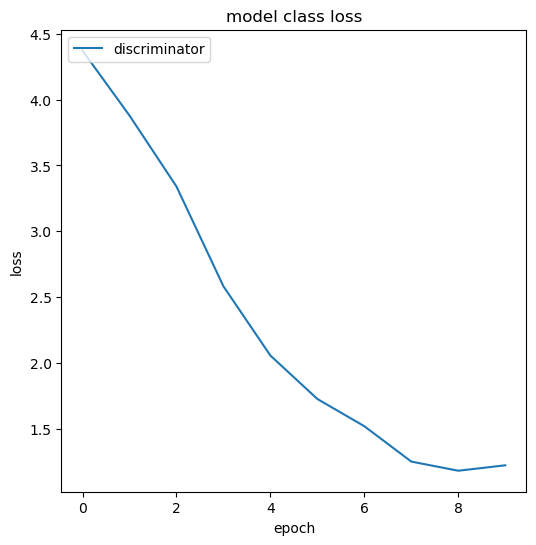

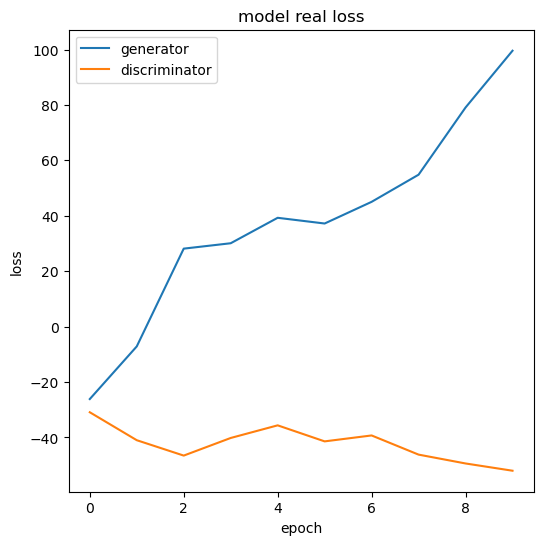

In [16]:
# plotting multi-class classification loss
plt.figure(figsize=(6,6))
plt.plot(history.history['discriminator_class_loss'])
plt.title('model class loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['discriminator'], loc='upper left')
plt.show()

# plotting binary classification loss
plt.figure(figsize=(6,6))
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_real_loss'])
plt.title('model real loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

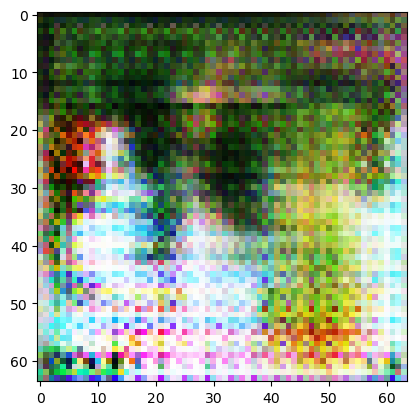

In [25]:
noise=  tf.random.normal([1, noise_shape]) # random noise
label = tf.Variable([81]) # label

pred = wcgan(noise,label) # classing class
plt.imshow((pred[0, :, :, :]+1)/2.0) # image result